In [2]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import imblearn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances )
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name], replace=True)
            df = pd.concat([df, sample], ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.concat([df, tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ]], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
        df.reset_index(drop=True, inplace=True)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)
        df.reset_index(drop=True, inplace=True)

    return df.sample(frac=1) 

In [105]:
# Cсылка на файлы
TRAIN_PART_PATH = 'train.csv'
TEST_PART_PATH = 'test.csv'

# Загрузка
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

# Отбор признаков для построения базовой модели

In [106]:
TARGET_NAME = 'Survived'
BASE_FEATURE_NAMES = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
                      'Embarked']

NUM_FEATURE_NAMES = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']

CAT_FEATURE_NAMES = ['Name', 'Sex', 'Cabin', 'Ticket', 'Embarked']

# Изучение данных для составления базовой модели

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Pclass'}>, <Axes: >]], dtype=object)

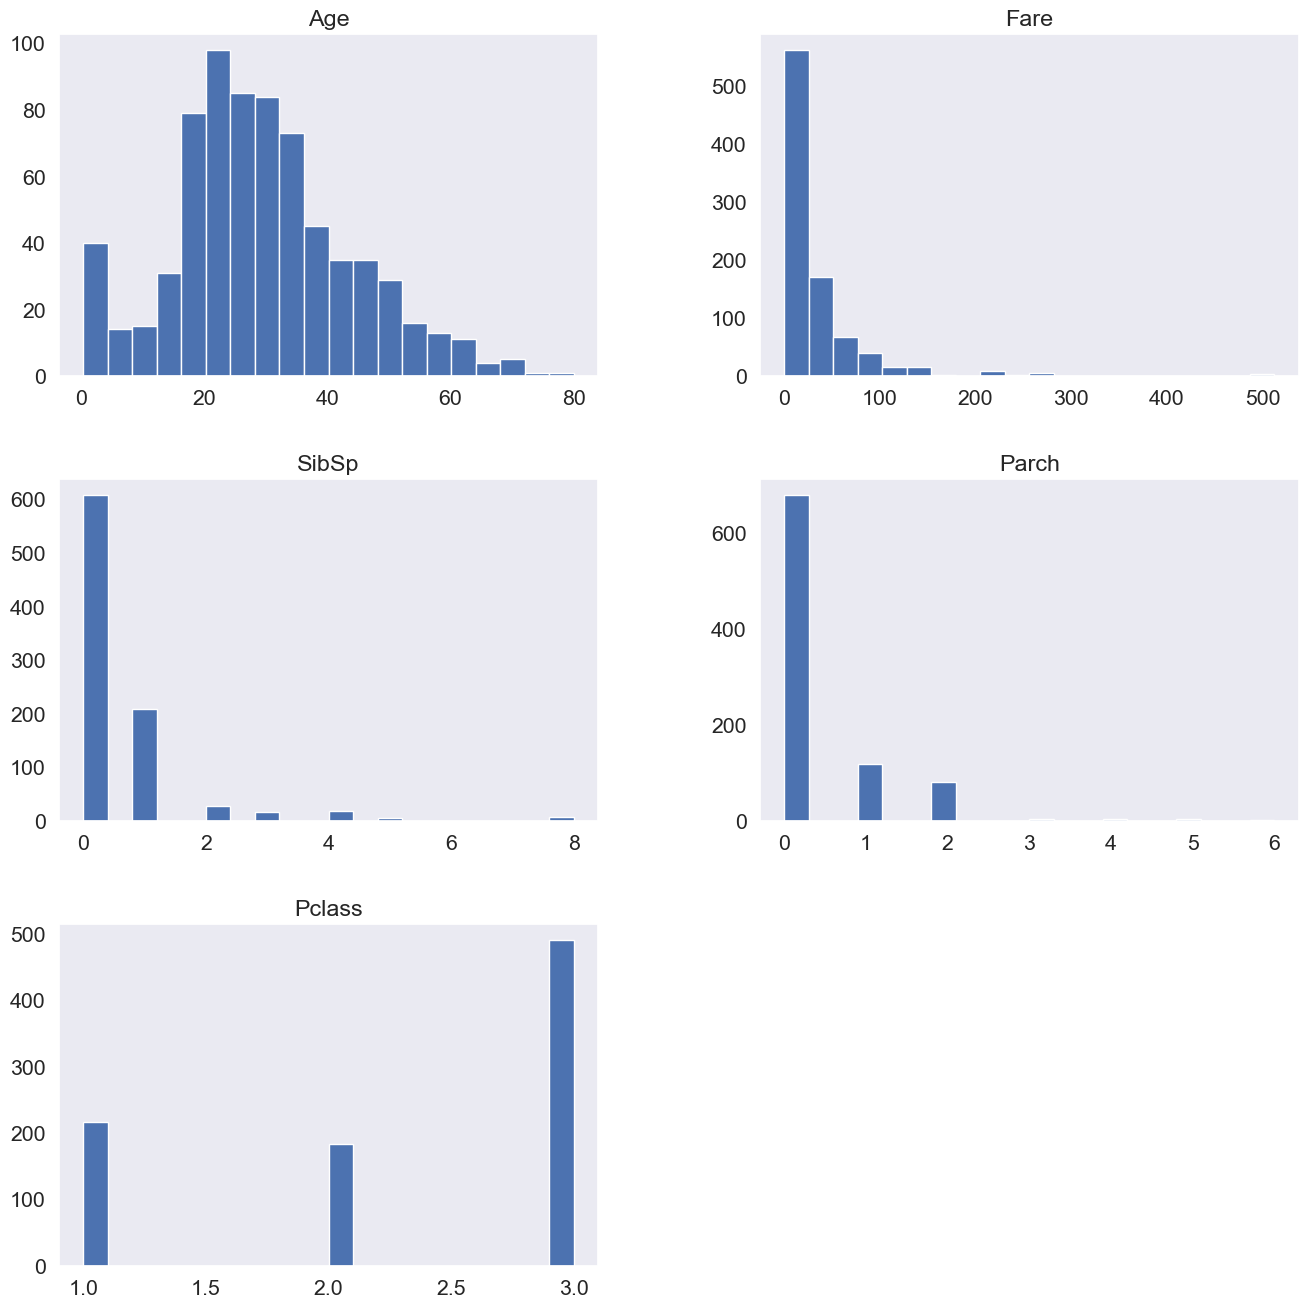

In [107]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False)

In [108]:
print(df_train['Sex'].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64


In [109]:
print(f'Размерность тренировочного датасета: {df_train.shape}')
for i in BASE_FEATURE_NAMES:
    a = df_train[i].isna().sum()
    print(f'Пропущено значений в столбце "{i}": {a}')    

Размерность тренировочного датасета: (891, 12)
Пропущено значений в столбце "PassengerId": 0
Пропущено значений в столбце "Pclass": 0
Пропущено значений в столбце "Name": 0
Пропущено значений в столбце "Sex": 0
Пропущено значений в столбце "Age": 177
Пропущено значений в столбце "SibSp": 0
Пропущено значений в столбце "Parch": 0
Пропущено значений в столбце "Ticket": 0
Пропущено значений в столбце "Fare": 0
Пропущено значений в столбце "Cabin": 687
Пропущено значений в столбце "Embarked": 2


In [111]:
print(f'Размерность трестового датасета: {df_test.shape}')
for i in BASE_FEATURE_NAMES:
    a = df_test[i].isna().sum()
    print(f'Пропущено значений в столбце "{i}": {a}') 

Размерность трестового датасета: (418, 11)
Пропущено значений в столбце "PassengerId": 0
Пропущено значений в столбце "Pclass": 0
Пропущено значений в столбце "Name": 0
Пропущено значений в столбце "Sex": 0
Пропущено значений в столбце "Age": 86
Пропущено значений в столбце "SibSp": 0
Пропущено значений в столбце "Parch": 0
Пропущено значений в столбце "Ticket": 0
Пропущено значений в столбце "Fare": 1
Пропущено значений в столбце "Cabin": 327
Пропущено значений в столбце "Embarked": 0


# Заполнение пропусков/выбросов для построения базовой моделии

Выбросы в данном датасете отсутствуют. Заполняем пропуски.

In [14]:
def get_median(df):
    df = df.copy()
    df.loc[df[i].isna(), i] = df[i].median()
    return df

i = 'Age'
df_train  =  get_median(df_train)   

# Построение базовой модели

In [15]:
X = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

Survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

In [16]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.89      0.79       384
           1       0.70      0.44      0.54       239

    accuracy                           0.71       623
   macro avg       0.71      0.66      0.67       623
weighted avg       0.71      0.71      0.70       623

TEST

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       165
           1       0.65      0.45      0.53       103

    accuracy                           0.69       268
   macro avg       0.68      0.65      0.65       268
weighted avg       0.69      0.69      0.68       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         140  25
1          57  46


# Предобработка датасета для построения основной модели

In [206]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class TitanicPreprocessor:
    def __init__(self):
        self.medians = {}
        self.modes = {}
        self.encoder = LabelEncoder()
        self.title_dummies = None

    def fit(self, X):  
        self.medians['Age'] = X['Age'].median()
        self.medians['Fare'] = X['Fare'].median()
        self.modes['Embarked'] = X['Embarked'].mode()[0] if not X['Embarked'].mode().empty else 'S'
        self.modes['Cabin'] = X['Cabin'].mode()[0] if not X['Cabin'].mode().empty else 'B96 B98'

        self.title_dummies = pd.get_dummies(X['Name'].str.extract(r",\s*([^\.]+)\.")[0]).columns.tolist()
        self.encoder.fit(X['Cabin'].fillna('unknown').apply(lambda x: x[0] if isinstance(x, str) else 'unknown'))

    def transform(self, X):
        X = X.copy()

        # Сохраняем целевую переменную, если она есть
        y = X['Survived'] if 'Survived' in X.columns else None
        if y is not None:
            X = X.drop(columns=['Survived'])

        # 1. Заполняем пропуски
        X['Age'] = X['Age'].fillna(self.medians['Age'])
        X['Fare'] = X['Fare'].fillna(self.medians['Fare'])
        X['Embarked'] = X['Embarked'].fillna(self.modes['Embarked'])
        X['Cabin'] = X['Cabin'].fillna(self.modes['Cabin'])

        # 2. Кодируем категориальные переменные (НО НЕ УДАЛЯЕМ ОРИГИНАЛ!)
        X['Embarked'] = X['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})
        X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

        # 3. Обрабатываем Deck
        X['Deck'] = X['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else 'unknown')
        X['Deck'] = X['Deck'].apply(lambda x: x if x in self.encoder.classes_ else 'unknown')
        X['Deck_encoded'] = self.encoder.transform(X['Deck'])

        # 4. Обрабатываем Title
        X['Title'] = X['Name'].str.extract(r",\s*([^\.]+)\.")[0]
        title_dummies = pd.get_dummies(X['Title'], prefix='Title')

        # Добавляем One-Hot Encoding (но сохраняем оригинальные данные!)
        X = pd.concat([X, title_dummies], axis=1)

        # Добавляем пропущенные dummy-фичи
        for col in self.title_dummies:
            if f'Title_{col}' not in X.columns:
                X[f'Title_{col}'] = 0

        # Возвращаем `Survived`, если это train
        if y is not None:
            X['Survived'] = y

        return X

# --- Применение ---
preprocessor = TitanicPreprocessor()
preprocessor.fit(df_train)  # Обучаем на train
X_prepr = preprocessor.transform(df_train)  # Преобразуем train
X_test_prepr = preprocessor.transform(df_test)

In [207]:
print(X_test_prepr.shape)
print(df_test.shape)
X_prepr

(418, 32)
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Survived
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,B96 B98,...,False,False,False,True,False,False,False,False,False,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,...,False,False,False,False,True,False,False,False,False,1
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,...,True,False,False,False,False,False,False,False,False,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,...,False,False,False,False,True,False,False,False,False,1
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,B96 B98,...,False,False,False,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,B96 B98,...,False,False,False,False,False,False,True,False,False,0
887,888,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,...,True,False,False,False,False,False,False,False,False,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,B96 B98,...,True,False,False,False,False,False,False,False,False,0
889,890,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,...,False,False,False,True,False,False,False,False,False,1


# Отбор признаков для построения основной модели

In [208]:
#Выделение признаков
TARGET_NAME = 'Survived'

BASE_FEATURE_NAMES = X_prepr.columns.drop(TARGET_NAME).tolist()
CAT_FEATURE_NAMES = list(X_prepr.select_dtypes(include=['object']).columns)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES) - (set(CAT_FEATURE_NAMES)))

#Приведение типов                      
X_prepr[TARGET_NAME] = X_prepr[TARGET_NAME].astype(int)
X_prepr[CAT_FEATURE_NAMES] = X_prepr[CAT_FEATURE_NAMES].astype(str)
X_prepr[NUM_FEATURE_NAMES] = X_prepr[NUM_FEATURE_NAMES].astype(int)

In [209]:
print((X_prepr[TARGET_NAME]).unique())
print((X_prepr[TARGET_NAME]).dtype)

[0 1]
int32


In [210]:
X_prepr[NUM_FEATURE_NAMES]

,Fare,Title_Major,Embarked,Title_Mme,Title_Dr,Parch,SibSp,Title_Master,Title_Col,Title_Mlle,...,Pclass,Title_Mr,Title_Miss,Title_Jonkheer,Deck_encoded,Title_Ms,Title_Lady,Title_Rev,Title_Mrs,Title_Capt
0,7,0,1,0,0,0,1,0,0,0,...,3,1,0,0,1,0,0,0,0,0
1,71,0,2,0,0,0,1,0,0,0,...,1,0,0,0,2,0,0,0,1,0
2,7,0,1,0,0,0,0,0,0,0,...,3,0,1,0,1,0,0,0,0,0
3,53,0,1,0,0,0,1,0,0,0,...,1,0,0,0,2,0,0,0,1,0
4,8,0,1,0,0,0,0,0,0,0,...,3,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13,0,1,0,0,0,0,0,0,0,...,2,0,0,0,1,0,0,1,0,0
887,30,0,1,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
888,23,0,1,0,0,2,1,0,0,0,...,3,0,1,0,1,0,0,0,0,0
889,30,0,2,0,0,0,0,0,0,0,...,1,1,0,0,2,0,0,0,0,0


# Масштабирование признаков

In [211]:
scaler = StandardScaler()
X_prepr_norm = X_prepr.copy()
X_prepr_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(X_prepr_norm[NUM_FEATURE_NAMES])
X_prepr = X_prepr_norm.copy()

In [212]:
print(X_prepr.dtypes)

PassengerId           float64
Pclass                float64
Name                   object
Sex                   float64
Age                   float64
SibSp                 float64
Parch                 float64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked              float64
Deck                   object
Deck_encoded          float64
Title                  object
Title_Capt            float64
Title_Col             float64
Title_Don             float64
Title_Dr              float64
Title_Jonkheer        float64
Title_Lady            float64
Title_Major           float64
Title_Master          float64
Title_Miss            float64
Title_Mlle            float64
Title_Mme             float64
Title_Mr              float64
Title_Mrs             float64
Title_Ms              float64
Title_Rev             float64
Title_Sir             float64
Title_the Countess    float64
Survived                int32
dtype: object


In [213]:
#Проверка на содержание столбцов тип object
for col in X_prepr.columns:
    if X_prepr[col].dtype == 'object':
        print(f"Колонка {col} содержит строки. Вот примеры значений:")
        print(X_prepr[col].unique()[:10])  # Покажет первые 10 уникальных значений

Колонка Name содержит строки. Вот примеры значений:
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
Колонка Ticket содержит строки. Вот примеры значений:
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736']
Колонка Cabin содержит строки. Вот примеры значений:
['B96 B98' 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78']
Колонка Deck содержит строки. Вот примеры значений:
['B' 'C' 'E' 'G' 'D' 'A' 'F' 'T']
Колонка Title содержит строки. Вот примеры значений:
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major']


# Построение моделей на новых признаках

Разбиение на трейн и тест + проверка на заданном тесте

In [214]:
X = X_prepr.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = X_prepr[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

Survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

Балансировка

In [215]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

Survived
1    384
0    384
Name: count, dtype: int64

In [216]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Logistic Regression

In [217]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       384
           1       0.86      0.78      0.82       384

    accuracy                           0.83       768
   macro avg       0.83      0.83      0.83       768
weighted avg       0.83      0.83      0.83       768

TEST

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       165
           1       0.84      0.72      0.77       103

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         151  14
1          29  74


Кросс валидация

In [218]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [219]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=4,
                                   cv=cv, Cs=[0.01], 
                                   )
model_lr_cv.fit(X_train, y_train)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       384
           1       0.86      0.76      0.81       384

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768

TEST

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       165
           1       0.82      0.67      0.74       103

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         150  15
1          34  69
CPU times: total: 62.5 ms
Wall time: 52.7 ms


# Support Vector Machine 

In [220]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train, y_train)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       384
           1       0.83      0.79      0.81       384

    accuracy                           0.81       768
   macro avg       0.81      0.81      0.81       768
weighted avg       0.81      0.81      0.81       768

TEST

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       165
           1       0.76      0.72      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         142  23
1          29  74
CPU times: total: 93.8 ms
Wall time: 84.9 ms


In [221]:
%%time
model_svc = SVC(C=0.1,
                kernel='poly',
                degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.97      0.79       384
           1       0.94      0.52      0.67       384

    accuracy                           0.74       768
   macro avg       0.80      0.74      0.73       768
weighted avg       0.80      0.74      0.73       768

TEST

              precision    recall  f1-score   support

           0       0.73      0.98      0.83       165
           1       0.91      0.42      0.57       103

    accuracy                           0.76       268
   macro avg       0.82      0.70      0.70       268
weighted avg       0.80      0.76      0.73       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         161   4
1          60  43
CPU times: total: 109 ms
Wall time: 171 ms


# XGBoost

In [224]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=3, 
#                              min_child_weight=1
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       384
           1       0.96      0.93      0.95       384

    accuracy                           0.95       768
   macro avg       0.95      0.95      0.95       768
weighted avg       0.95      0.95      0.95       768

TEST

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       165
           1       0.77      0.77      0.77       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         141  24
1          24  79


In [225]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [226]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [227]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

{'reg_lambda': 1.9}

0.8195526299185815

CPU times: total: 10.6 s
Wall time: 1.57 s


In [230]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=2
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       384
           1       0.85      0.85      0.85       384

    accuracy                           0.85       768
   macro avg       0.85      0.85      0.85       768
weighted avg       0.85      0.85      0.85       768

TEST

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       165
           1       0.76      0.81      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         139  26
1          20  83


In [231]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [232]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [233]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

{'reg_lambda': 0.5}

0.8220730383916625

CPU times: total: 8.36 s
Wall time: 1.13 s


In [234]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=1
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       384
           1       0.85      0.85      0.85       384

    accuracy                           0.85       768
   macro avg       0.85      0.85      0.85       768
weighted avg       0.85      0.85      0.85       768

TEST

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       165
           1       0.77      0.81      0.79       103

    accuracy                           0.83       268
   macro avg       0.82      0.83      0.82       268
weighted avg       0.83      0.83      0.83       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         140  25
1          20  83


In [235]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_st

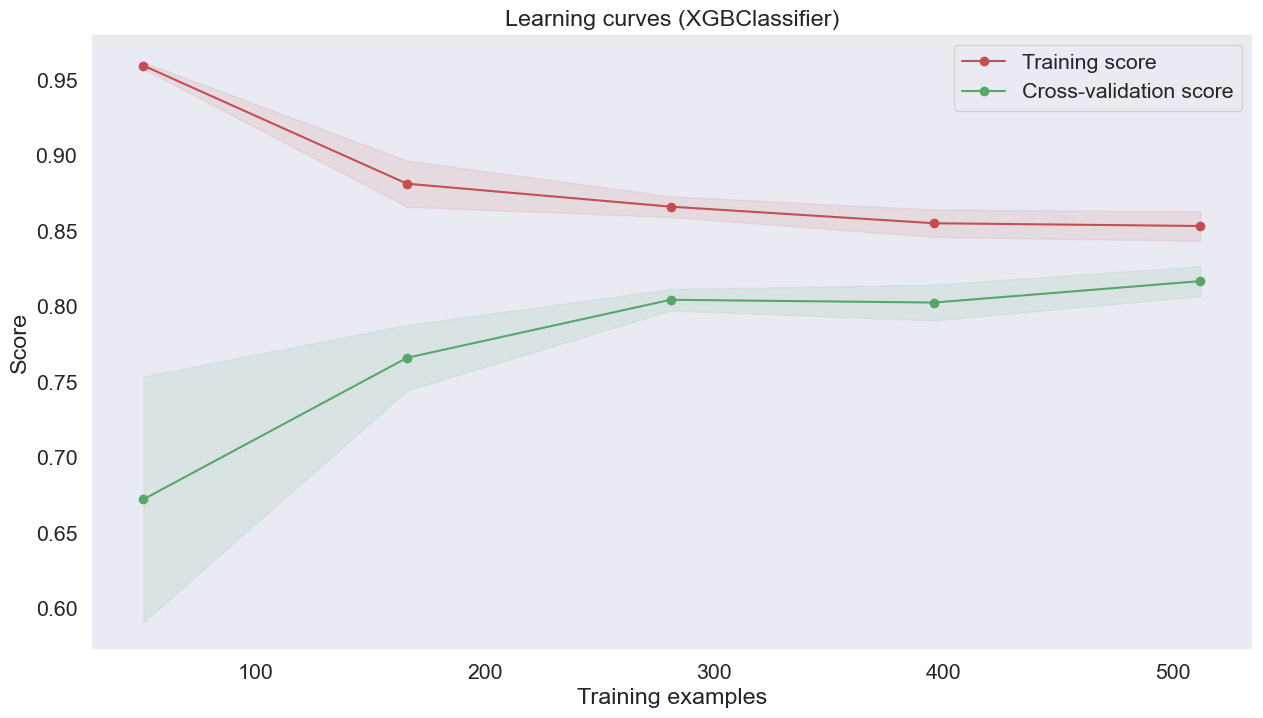

In [236]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

In [237]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances )
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



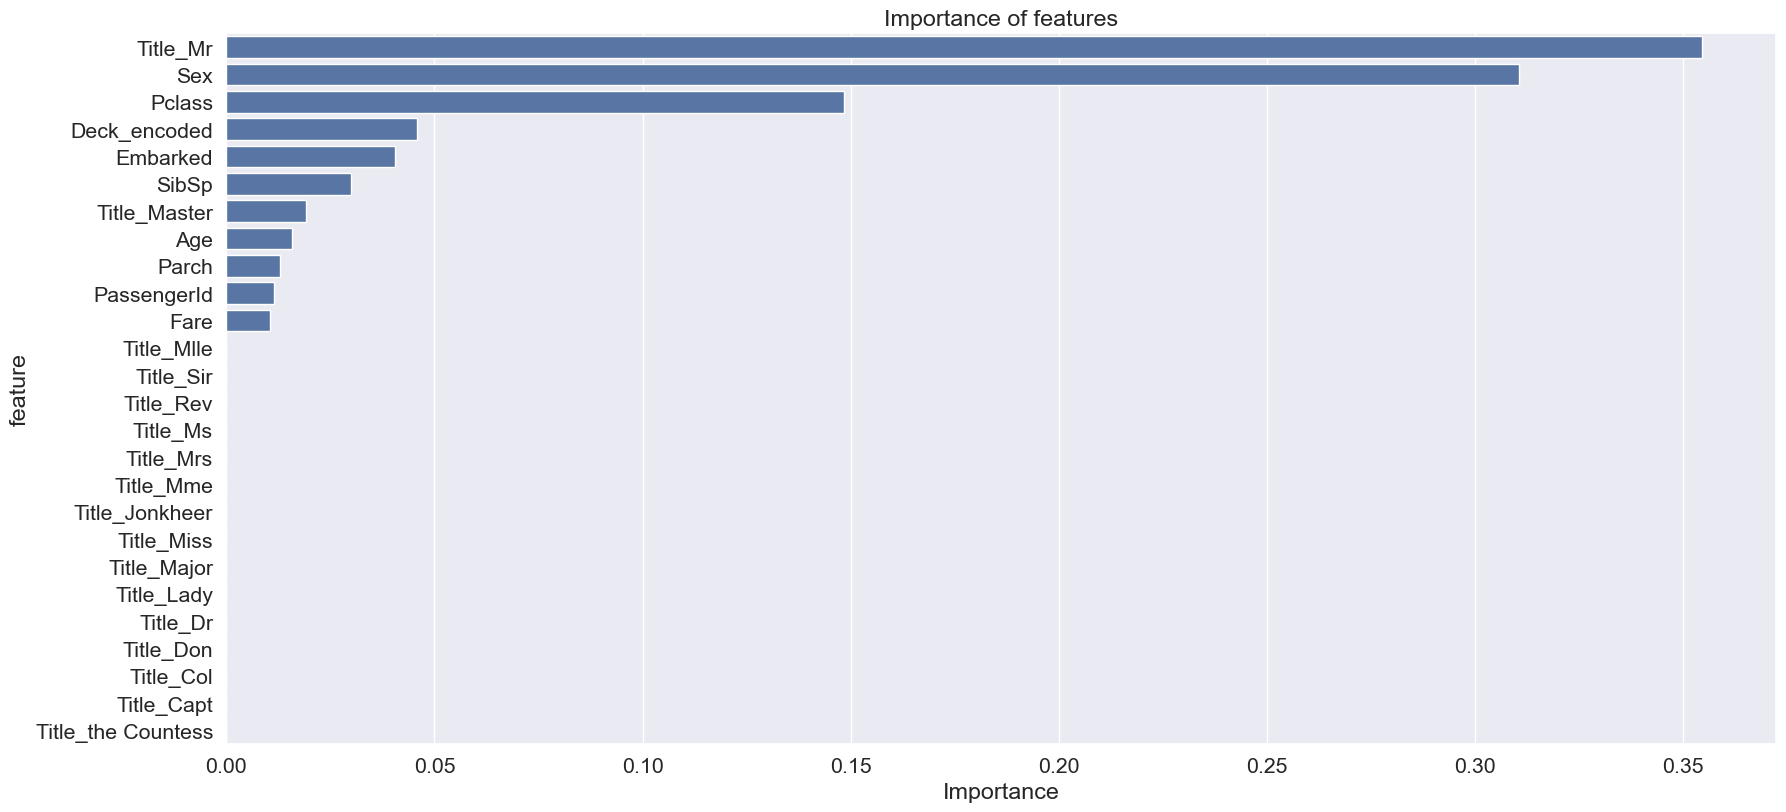

In [238]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=23)

In [239]:
important_features_top

['Title_Mr',
 'Sex',
 'Pclass',
 'Deck_encoded',
 'Embarked',
 'SibSp',
 'Title_Master',
 'Age',
 'Parch',
 'PassengerId',
 'Fare',
 'Title_Mlle',
 'Title_Sir',
 'Title_Rev',
 'Title_Ms',
 'Title_Mrs',
 'Title_Mme',
 'Title_Jonkheer',
 'Title_Miss',
 'Title_Major',
 'Title_Lady',
 'Title_Dr',
 'Title_Don']

# Catboost

In [240]:
#Отбор признаков
TARGET_NAME = 'Survived'

BASE_FEATURE_NAMES = X_prepr.columns.drop(TARGET_NAME).tolist()
CAT_FEATURE_NAMES = list(X_prepr.select_dtypes(include=['object']).columns)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES) - (set(CAT_FEATURE_NAMES)))

#Приведение типов
X_prepr[TARGET_NAME] = X_prepr[TARGET_NAME].astype(int)
X_prepr[CAT_FEATURE_NAMES] = X_prepr[CAT_FEATURE_NAMES].astype(str)
X_prepr[NUM_FEATURE_NAMES] = X_prepr[NUM_FEATURE_NAMES].astype(int)

In [241]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

1.606694560669456

In [242]:
# Разделяем train на train/valid
X = X_prepr[BASE_FEATURE_NAMES]
y = X_prepr[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=32)

In [243]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':40
}

In [244]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       441
           1       0.84      0.86      0.85       271

    accuracy                           0.88       712
   macro avg       0.88      0.88      0.88       712
weighted avg       0.89      0.88      0.89       712

TEST

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       108
           1       0.74      0.82      0.78        71

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.82      0.82      0.82       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         88  20
1         13  58
CPU times: total: 5.36 s
Wall time: 3.08 s


In [245]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       441
           1       0.74      0.81      0.78       271

    accuracy                           0.82       712
   macro avg       0.81      0.82      0.81       712
weighted avg       0.83      0.82      0.82       712

TEST

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       108
           1       0.75      0.76      0.76        71

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         90  18
1         17  54


In [246]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [247]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [248]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [249]:
grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.869551153
bestIteration = 4

0:	loss: 0.8695512	best: 0.8695512 (0)	total: 1.29s	remaining: 1m 3s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.870037148
bestIteration = 34

1:	loss: 0.8700371	best: 0.8700371 (1)	total: 3.4s	remaining: 1m 21s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.869551153
bestIteration = 4

2:	loss: 0.8695512	best: 0.8700371 (1)	total: 4.61s	remaining: 1m 12s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8755501359
bestIteration = 47

3:	loss: 0.8755501	best: 0.8755501 (3)	total: 6.7s	remaining: 1m 16s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8811334353
bestIteration = 56

4:	loss: 0.8811334	best: 0.8811334 (4)	total: 9.07s	remaining: 1m 21s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.870037148
bestIteration = 33

5:	loss: 0.8700371	best: 0.8811334 (4)	total: 10.9s	remaining: 1m

In [250]:
grid_search

{'params': {'l2_leaf_reg': 0.7911392405063291},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
   

In [251]:
%%time

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       441
           1       0.96      0.88      0.92       271

    accuracy                           0.94       712
   macro avg       0.95      0.93      0.94       712
weighted avg       0.94      0.94      0.94       712

TEST

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       108
           1       0.72      0.80      0.76        71

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.81      0.80      0.80       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         86  22
1         14  57
CPU times: total: 31.2 ms
Wall time: 19.5 ms


# Отбор финальной модели

# Отбор признаков для финальной модели

In [252]:
#Выделение признаков
TARGET_NAME = 'Survived'

SELCTED_FEATURE_NAMES = ['Title_Mr', 
                         'Sex', 
                         'Pclass', 
                         'Embarked', 
#                         'Deck_encoded', 
                         'SibSp',  
                         'Age', 
                         'Fare', 
 #                        'PassengerId', 
                         'Title_Master', 
                         'Parch']

#Приведение типов                      
X_prepr[SELCTED_FEATURE_NAMES] = X_prepr[SELCTED_FEATURE_NAMES].astype(int)


In [253]:
#Проверка на содержание признаков в тестовом датасете
for i in SELCTED_FEATURE_NAMES:
    if i in X_test_prepr.columns.tolist():
        f = 'Все отобранные признаки присутстуют в тестовом датасете'
    else:
        f = 'Что-то пошло не так('
print (f)

Все отобранные признаки присутстуют в тестовом датасете


# Масштабирование отобраных признаков

In [156]:
scaler = StandardScaler()
X_prepr_norm = X_prepr.copy()
X_prepr_norm[SELCTED_FEATURE_NAMES] = scaler.fit_transform(X_prepr_norm[SELCTED_FEATURE_NAMES])
X_prepr = X_prepr_norm.copy()

# Проверка корреляции

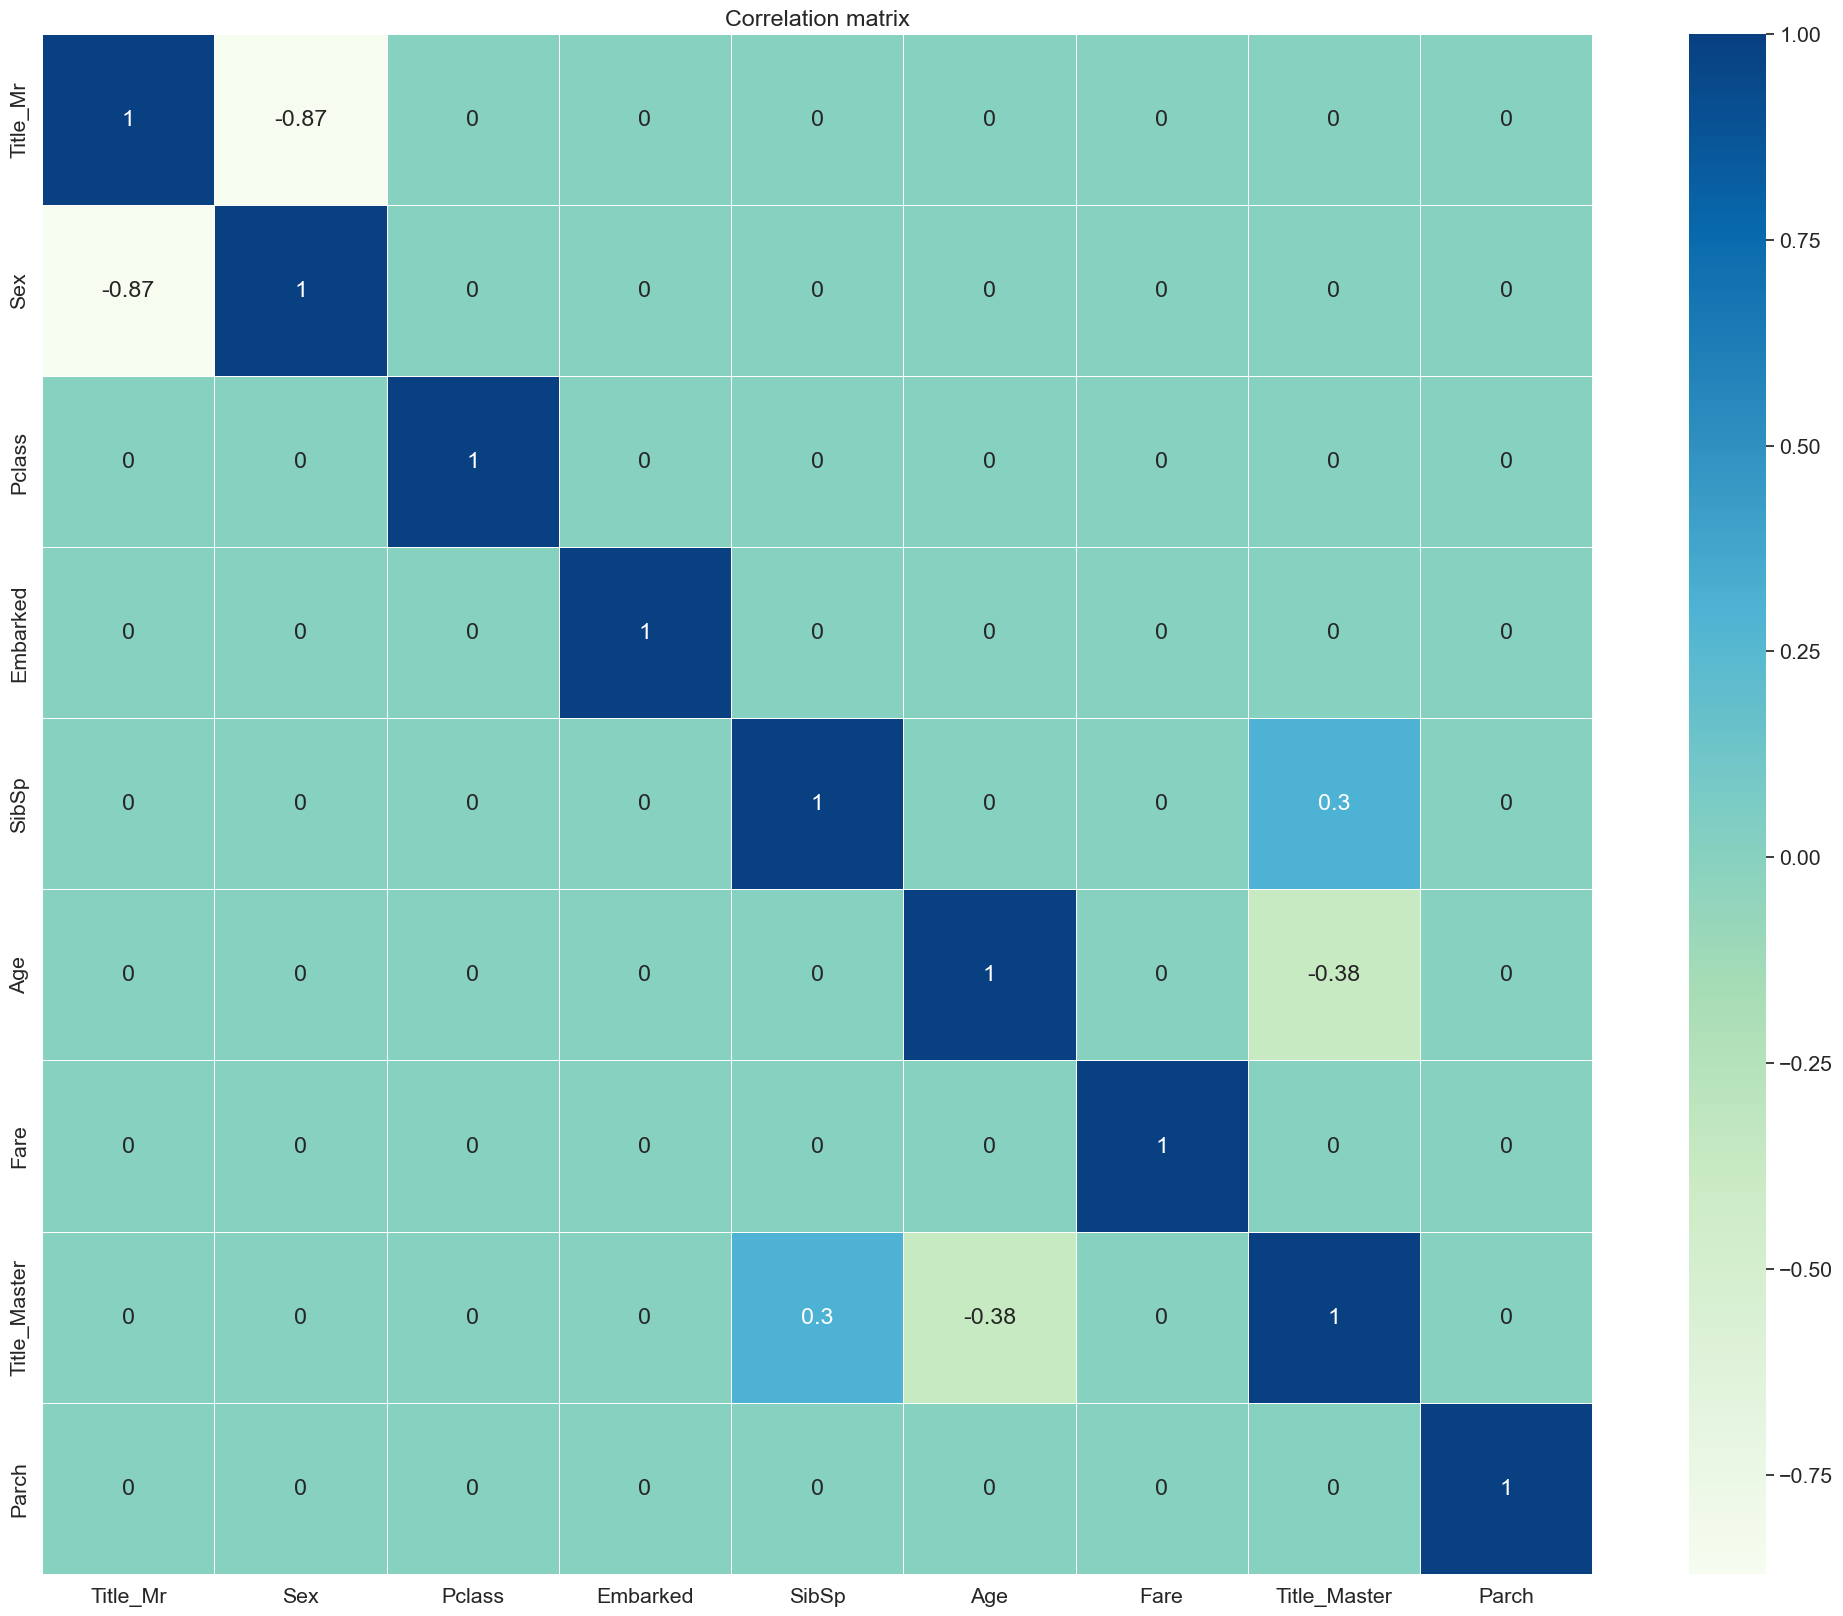

In [157]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = X_prepr[SELCTED_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Построение моделей 

In [254]:
X = X_prepr[SELCTED_FEATURE_NAMES]
y = X_prepr[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

Survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

Балансировкаа

In [255]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

Survived
0    384
1    384
Name: count, dtype: int64

In [256]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# LogisticRegression

In [257]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       384
           1       0.85      0.74      0.79       384

    accuracy                           0.81       768
   macro avg       0.81      0.81      0.81       768
weighted avg       0.81      0.81      0.81       768

TEST

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       165
           1       0.85      0.69      0.76       103

    accuracy                           0.83       268
   macro avg       0.84      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         152  13
1          32  71


In [258]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [259]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=4,
                                   cv=cv, Cs=[0.01], 
                                   )
model_lr_cv.fit(X_train, y_train)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       384
           1       0.91      0.47      0.62       384

    accuracy                           0.71       768
   macro avg       0.78      0.71      0.70       768
weighted avg       0.78      0.71      0.70       768

TEST

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       165
           1       0.89      0.49      0.63       103

    accuracy                           0.78       268
   macro avg       0.82      0.72      0.74       268
weighted avg       0.80      0.78      0.76       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         159   6
1          53  50
CPU times: total: 46.9 ms
Wall time: 46.9 ms


# Обучение теста на LogisticRegression

# Отбор признаков

In [260]:
SELCTED_FEATURE_NAMES = ['Title_Mr', 
                         'Sex', 
                         'Pclass', 
                         'Embarked', 
#                         'Deck_encoded', 
                         'SibSp',  
                         'Age', 
                         'Fare', 
#                         'PassengerId',
                         'Title_Master', 
                         'Parch']

#Приведение типов                      
X_test_prepr[SELCTED_FEATURE_NAMES] = X_test_prepr[SELCTED_FEATURE_NAMES].astype(int)

In [261]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Обучение модели
model_log = LogisticRegression(solver='liblinear')  # Можно использовать другие солверы в зависимости от задачи
model_log.fit(X_train_balanced, y_train_balanced)

# Предсказания
y_train_pred = model_log.predict(X_train_balanced)
y_pred = model_log.predict(X_test_prepr[SELCTED_FEATURE_NAMES])

# Оценка модели
evaluate_preds(model_log, X_train_balanced, X_test_prepr[SELCTED_FEATURE_NAMES], y_train_balanced, y_pred)


# Сохранение в submission
#test_ids = df_test['PassengerId']
#submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})# cоздаем DataFrame с результатами
#submission.to_csv('submission.csv', index=False) # cохраняем файл в CSV

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       384
           1       0.81      0.84      0.83       384

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00        38

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418

CONFUSION MATRIX

col_0    0   1
row_0         
0      380   0
1        0  38


# Support Vector Machine

In [262]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train, y_train)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       384
           1       0.84      0.77      0.80       384

    accuracy                           0.81       768
   macro avg       0.81      0.81      0.81       768
weighted avg       0.81      0.81      0.81       768

TEST

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       165
           1       0.79      0.73      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         145  20
1          28  75
CPU times: total: 93.8 ms
Wall time: 89.3 ms


In [263]:
%%time
model_svc = SVC(C=0.1,
                kernel='poly',
                degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.92      0.79       384
           1       0.88      0.59      0.71       384

    accuracy                           0.76       768
   macro avg       0.79      0.76      0.75       768
weighted avg       0.79      0.76      0.75       768

TEST

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       165
           1       0.84      0.59      0.69       103

    accuracy                           0.80       268
   macro avg       0.81      0.76      0.77       268
weighted avg       0.80      0.80      0.79       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         153  12
1          42  61
CPU times: total: 78.1 ms
Wall time: 68.1 ms


In [264]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


# Обучение модели
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(X_train_balanced, y_train_balanced)

# Предсказания
y_train_pred = model_svm.predict(X_train_balanced)
y_pred = model_svm.predict(X_test_prepr[SELCTED_FEATURE_NAMES])

evaluate_preds(model_svm, X_train_balanced, X_test_prepr[SELCTED_FEATURE_NAMES], y_train_balanced, y_pred)

# Сохранение в submission
#test_ids = df_test['PassengerId']
#submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})# cоздаем DataFrame с результатами
#submission.to_csv('submission.csv', index=False) # cохраняем файл в CSV

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       384
           1       0.85      0.76      0.80       384

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.81       768
weighted avg       0.82      0.82      0.81       768

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       409

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418

CONFUSION MATRIX

col_0  0    1
row_0        
0      9    0
1      0  409


# XGBoost

In [298]:
model_xgb = xgb.XGBClassifier(
    max_depth=1,  
#    min_child_weight=5,  
#    reg_lambda=10,  
#    reg_alpha=1,  
#    gamma=0.5,  
#    n_estimators=80,  
#    scale_pos_weight=len(y_train_balanced) / sum(y_train_balanced),
    random_state=21
)
                              
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       384
           1       0.82      0.86      0.84       384

    accuracy                           0.84       768
   macro avg       0.84      0.84      0.84       768
weighted avg       0.84      0.84      0.84       768

TEST

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       165
           1       0.73      0.79      0.76       103

    accuracy                           0.81       268
   macro avg       0.79      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         135  30
1          22  81


In [299]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [300]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [301]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

{'reg_lambda': 0.2}

0.818304649678609

CPU times: total: 5.95 s
Wall time: 802 ms


In [303]:
model_xgb = xgb.XGBClassifier(
 
    max_depth=1,  
#    min_child_weight=5,  
    reg_lambda=10,  
#    reg_alpha=1,  
#    gamma=0.5,  
#    n_estimators=80,  
#    scale_pos_weight=len(y_train_balanced) / sum(y_train_balanced),
    random_state=21
)
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       384
           1       0.81      0.86      0.83       384

    accuracy                           0.83       768
   macro avg       0.83      0.83      0.83       768
weighted avg       0.83      0.83      0.83       768

TEST

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       165
           1       0.71      0.82      0.76       103

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.80       268
weighted avg       0.81      0.80      0.80       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         131  34
1          19  84


# Обучение теста на XGBoost (выбрана в качестве финальной модели)

In [304]:
SELCTED_FEATURE_NAMES = ['Title_Mr', 
                         'Sex', 
                         'Pclass', 
                         'Embarked', 
#                         'Deck_encoded', 
                         'SibSp',  
                         'Age', 
                         'Fare', 
#                         'PassengerId',
                         'Title_Master', 
                         'Parch']


#Приведение типов                      
X_test_prepr[SELCTED_FEATURE_NAMES] = X_test_prepr[SELCTED_FEATURE_NAMES].astype(int)

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Обучение модели
model_xgb = XGBClassifier(eval_metric='logloss')
model_xgb.fit(X_train_balanced, y_train_balanced)

#Предсказания
y_train_pred = model_xgb.predict(X_test_prepr[SELCTED_FEATURE_NAMES])
y_pred = model_xgb.predict(X_test_prepr[SELCTED_FEATURE_NAMES])

evaluate_preds(model_xgb, X_train_balanced, X_test_prepr[SELCTED_FEATURE_NAMES], y_train_balanced, y_pred)


# Сохранение в submission
test_ids = df_test['PassengerId']
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})# cоздаем DataFrame с результатами
submission.to_csv('submission.csv', index=False) # cохраняем файл в CSV

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       384
           1       0.84      0.86      0.85       384

    accuracy                           0.85       768
   macro avg       0.85      0.85      0.85       768
weighted avg       0.85      0.85      0.85       768

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00       292

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418

CONFUSION MATRIX

col_0    0    1
row_0          
0      126    0
1        0  292


# CATBoost

In [176]:
#Выделение признаков
TARGET_NAME = 'Survived'
SELCTED_FEATURE_NAMES = ['Title_Mr',
                         'Sex', 
                         'Pclass', 
                         'Embarked', 
#                         'Deck_encoded', 
                         'SibSp',  
                         'Age', 
                         'Fare', 
#                         'PassengerId', 
                         'Title_Master', 
                         'Parch']

#Приведение типов                      
X_prepr[SELCTED_FEATURE_NAMES] = X_prepr[SELCTED_FEATURE_NAMES].astype(int)


In [177]:
# Разделяем train на train/valid
X = X_prepr[SELCTED_FEATURE_NAMES]
y = X_prepr[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=32)

In [178]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
#     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':40
}

In [179]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=10)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       441
           1       0.79      0.79      0.79       271

    accuracy                           0.84       712
   macro avg       0.83      0.83      0.83       712
weighted avg       0.84      0.84      0.84       712

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       108
           1       0.76      0.75      0.75        71

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         91  17
1         18  53
CPU times: total: 1.14 s
Wall time: 291 ms


In [180]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=10, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       441
           1       0.79      0.78      0.78       271

    accuracy                           0.84       712
   macro avg       0.83      0.83      0.83       712
weighted avg       0.84      0.84      0.84       712

TEST

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       108
           1       0.76      0.72      0.74        71

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         92  16
1         20  51


In [181]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [182]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=10)

In [183]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [184]:
grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 29

0:	loss: 0.8577266	best: 0.8577266 (0)	total: 172ms	remaining: 8.42s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 5

1:	loss: 0.8577266	best: 0.8577266 (0)	total: 242ms	remaining: 5.81s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 5

2:	loss: 0.8577266	best: 0.8577266 (0)	total: 317ms	remaining: 4.97s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 5

3:	loss: 0.8577266	best: 0.8577266 (0)	total: 407ms	remaining: 4.68s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 7

4:	loss: 0.8577266	best: 0.8577266 (0)	total: 512ms	remaining: 4.61s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8577265675
bestIteration = 19

5:	loss: 0.8577266	best: 0.8577266 (0)	total: 647ms	remaining: 4.

In [150]:
grid_search

{'params': {'l2_leaf_reg': 4},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
 

In [185]:
%%time

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       441
           1       0.80      0.80      0.80       271

    accuracy                           0.85       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.85      0.85      0.85       712

TEST

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       108
           1       0.76      0.75      0.75        71

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

CONFUSION MATRIX

col_0      0   1
Survived        
0         91  17
1         18  53
CPU times: total: 31.2 ms
Wall time: 33.3 ms


# Обучение теста на CATBoost

# Отбор признаков на тесте

In [186]:
SELCTED_FEATURE_NAMES = ['Title_Mr',
                         'Sex', 
                         'Pclass', 
                         'Embarked', 
#                         'Deck_encoded', 
                         'SibSp',  
                         'Age', 
                         'Fare', 
#                         'PassengerId', 
                         'Title_Master', 
                         'Parch']

#Приведение типов                      
X_test_prepr[SELCTED_FEATURE_NAMES] = X_test_prepr[SELCTED_FEATURE_NAMES].astype(int)


In [187]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier

#Обучение модели
model_сtb = CatBoostClassifier(iterations=2000, depth=3, learning_rate=0.1, loss_function='Logloss', verbose=100)
model_сtb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

#Предсказания
y_train_pred = model_сtb.predict(X_test_prepr[SELCTED_FEATURE_NAMES])
y_pred = model_сtb.predict(X_test_prepr[SELCTED_FEATURE_NAMES])

evaluate_preds(model_сtb, X_train, X_test_prepr[SELCTED_FEATURE_NAMES], y_train, y_pred)


# Сохранение в submission
#test_ids = df_test['PassengerId']
#submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})# cоздаем DataFrame с результатами
#submission.to_csv('submission.csv', index=False) # cохраняем файл в CSV

0:	learn: 0.6546943	test: 0.6551116	best: 0.6551116 (0)	total: 1.56ms	remaining: 3.12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4502102401
bestIteration = 49

Shrink model to first 50 iterations.
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       441
           1       0.80      0.76      0.78       271

    accuracy                           0.84       712
   macro avg       0.83      0.82      0.83       712
weighted avg       0.84      0.84      0.84       712

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       416
           1       1.00      1.00      1.00         2

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418

CONFUSION MATRIX

col_0    0  1
row_0        
0      416  0
1        0  2
